# Exploratory Data Analysis of Iris Dataset

## Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ternary
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score

In [2]:
iris = datasets.load_iris()

In [3]:
# shape of predictor
iris.data.shape

(150, 4)

In [4]:
# shape of outcomes
iris.target.shape

(150,)

In [5]:
X = iris.data
y = iris.target

In [6]:
# predictor summary
print("X   predictor      mean   sd     min    .25    med    .75    max")
for i, x in enumerate(["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]):
    print("%d   %s%.4a   %.4a   " % (i, x.ljust(15), X[:,i].mean(), X[:,i].std()), end="")
    for a in np.quantile(X[:, i], (0, 0.25, 0.5, 0.75, 1)):
        print("%.2f   " % a, end="")
    print("")

X   predictor      mean   sd     min    .25    med    .75    max
0   Sepal Length   5.84   0.82   4.30   5.10   5.80   6.40   7.90   
1   Sepal Width    3.05   0.43   2.00   2.80   3.00   3.30   4.40   
2   Petal Length   3.75   1.75   1.00   1.60   4.35   5.10   6.90   
3   Petal Width    1.19   0.75   0.10   0.30   1.30   1.80   2.50   


## PCA visualization

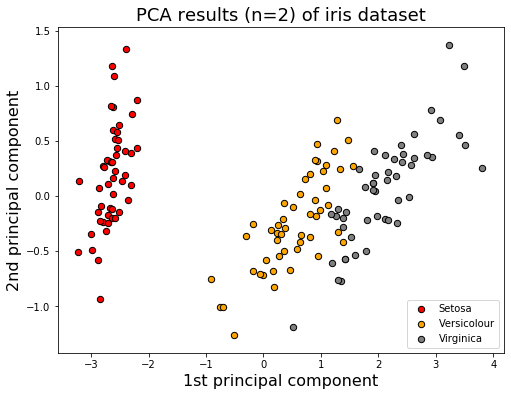

In [7]:
# PCA with 2 components
X_pca = PCA(n_components=2).fit_transform(X)

# plot the iris data on the 2 principal component space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:50, 0], X_pca[:50, 1], c="red", edgecolor='k', s=40, label="Setosa")
plt.scatter(X_pca[50:100, 0], X_pca[50:100, 1], c="orange", edgecolor='k', s=40, label="Versicolour")
plt.scatter(X_pca[100:, 0], X_pca[100:, 1], c="gray", edgecolor='k', s=40, label = "Virginica")
plt.title("PCA results (n=2) of iris dataset", fontsize=18)
plt.xlabel("1st principal component", fontsize=16)
plt.ylabel("2nd principal component", fontsize=16)
plt.legend(loc="lower right")
plt.savefig("EDA-pca.png")
plt.show()

It seems that the PCA result of iris dataset is almost linear seperable

## PCA + Logistic Regression

I am not doing train test split in the EDA section on purpose. I will do that in the later section of model training.

In [8]:
# fit a logistic regression on the PCA transformed iris dataset
clf = LogisticRegression(solver="lbfgs", multi_class="auto").fit(X_pca, y)

# get predictions and prediction probabilities
probs = clf.predict_proba(X_pca)
preds = clf.predict(X_pca)

### Performance Metrics

In [9]:
print("accuracy: %.6f" % accuracy_score(y, preds))
print("macro-f1 score: %.6f" % f1_score(y, preds, average="macro"))
print("micro-f1 score: %.6f" % f1_score(y, preds, average="micro"))
print("area uder ROC curve: %.4f" % roc_auc_score(y, probs, average="macro", multi_class="ovo"))

accuracy: 0.966667
macro-f1 score: 0.966663
micro-f1 score: 0.966667
area uder ROC curve: 0.9972


### various ROC curves

In [10]:
n_classes = len(np.unique(y))
y_binary = label_binarize(y, classes=range(n_classes))  # binarize outcomes for class specific analysis
fpr = dict()  # false positive rates
tpr = dict()  # true positive rates
roc_auc = dict()  # area under ROC curve

## class specific ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

## micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## macro-average ROC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
sum_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    sum_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr = sum_tpr / n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

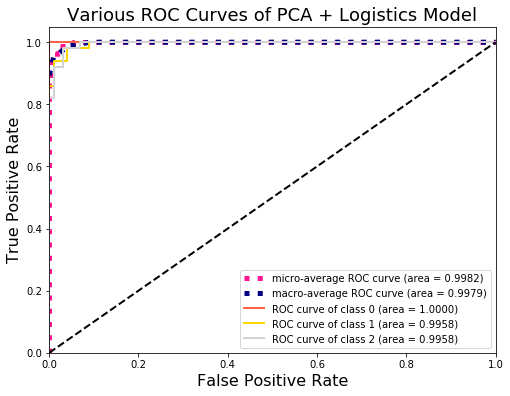

In [11]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=5)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=5)
colors = ['tomato', 'gold', 'lightgray']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Various ROC Curves of PCA + Logistics Model', fontsize=18)
plt.legend(loc="lower right")
plt.savefig("EDA-pca-logistic-roc.png")
plt.show()

### Predictions on PCA Space

In [12]:
# setting sizes and boundaries
figsizex = 8
figsizey = 6
res = 10
xmin = -4
xmax = 4.5
ymin = -1.6
ymax = 1.8

# making grids
nx = figsizex * res
ny = figsizey * res
xaxis = np.linspace(xmin, xmax, nx)
yaxis = np.linspace(ymin, ymax, ny)
XX, YY = np.meshgrid(xaxis, yaxis)
XX = XX.flatten()
YY = YY.flatten()
XY = np.stack([XX, YY], axis=1)

In [13]:
# making predictions on all the grids
XY_preds = clf.predict(XY)
grid_id0 = np.where(XY_preds == 0)
grid_id1 = np.where(XY_preds == 1)
grid_id2 = np.where(XY_preds == 2)

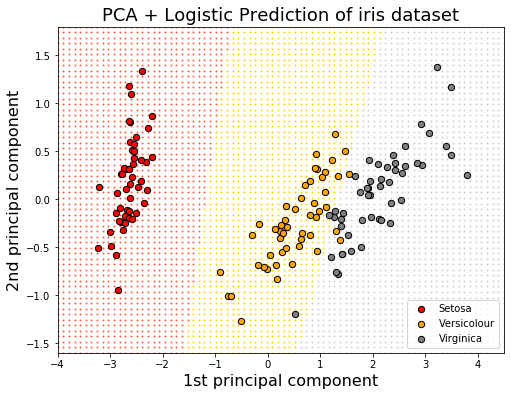

In [14]:
# plot grid predicitons and ground truths
plt.figure(figsize=(figsizex, figsizey))
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.scatter(XX[grid_id0], YY[grid_id0], s=1, color='tomato')
plt.scatter(XX[grid_id1], YY[grid_id1], s=1, color='gold')
plt.scatter(XX[grid_id2], YY[grid_id2], s=1, color='lightgray')
plt.scatter(X_pca[:50, 0], X_pca[:50, 1], c="red", edgecolor='k', s=40, label="Setosa")
plt.scatter(X_pca[50:100, 0], X_pca[50:100, 1], c="orange", edgecolor='k', s=40, label="Versicolour")
plt.scatter(X_pca[100:, 0], X_pca[100:, 1], c="gray", edgecolor='k', s=40, label = "Virginica")
plt.title("PCA + Logistic Prediction of iris dataset", fontsize=18)
plt.xlabel("1st principal component", fontsize=16)
plt.ylabel("2nd principal component", fontsize=16)
plt.legend(loc="lower right")
plt.savefig("EDA-pca-logistic-predictions.png")
plt.show()

### Ternary Predictions Plot

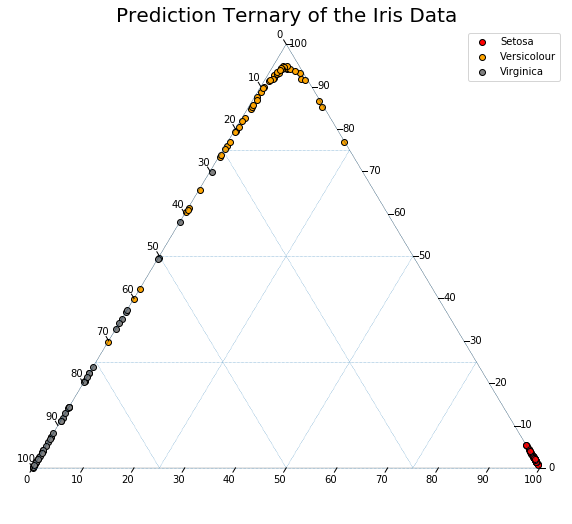

In [15]:
# ternary plots: the more pushed away towards corner the better classification prediction

probs = probs * 100  # change to percentage scale

fig, tax = ternary.figure(scale=100)
tax.boundary(linewidth=0.2)
fig.set_size_inches(10, 9)
tax.set_title("Prediction Ternary of the Iris Data", fontsize=20)
tax.scatter(probs[:50], edgecolor="k", color="red", label="Setosa")
tax.scatter(probs[50:100], edgecolor="k", color="orange", label="Versicolour")
tax.scatter(probs[100:], edgecolor="k", color="gray", label="Virginica")
tax.legend()
tax.gridlines(multiple=25)
tax.ticks(axis='lbr', linewidth=1, multiple=10)
tax.get_axes().axis('off')
plt.savefig("EDA-pca-logistic-ternary.png")
tax.show()